In [0]:
def kNN(X,Y,newx,k,regress=True,allK=False,leave1out=False,scaleX=True,scaler='standard'):

  import warnings
  warnings.filterwarnings('ignore')

  import numpy as np
  import pandas as pd

  from sklearn.neighbors import KNeighborsClassifier 
  from sklearn.neighbors import KNeighborsRegressor

  from sklearn.preprocessing import StandardScaler
  #from sklearn.preprocessing import MinMaxScaler
  #from sklearn.preprocessing import RobustScaler

  from statistics import mean 
  from statistics import mode
  from collections import Counter

  def kNNtype(neighbs,regress):
    if regress:
      knn = KNeighborsRegressor(n_neighbors=neighbs)
    else:
      knn = KNeighborsClassifier(n_neighbors=neighbs)
    return knn

  if scaler != 'standard':
    scaler = scaler
  else:
    scaler = StandardScaler()

# Update: for row subsets/test sets in hw; fitting the scaing function should be done separate
# so the same can be applied to train and test data (or X and newx) 
  if scaleX == True:
    # scale should be fit to X/train
    scaler.fit(X)
    columns_X = [list(X.columns)]
    for feature in columns_X:
      X[feature] = scaler.transform(X[feature])
      newx[feature] = scaler.transform(newx[feature])

  knn_all = pd.DataFrame()
  if allK == True:
    if leave1out == True:
      nn_all = []
      for j in list(newx.index.values.tolist()):
      #for j in list(Y.index.values.tolist()):
        knn_row = []
        knn = kNNtype(k+1,regress)
        knn.fit(X, Y)
        test = pd.DataFrame(newx.loc[j,:])
        nn = knn.kneighbors(test.T)[1][0]
        for i in range(2,k+1):
          nn1 = nn[1:i] # leave one out
          test = list(Y.iloc[nn1])
          if regress:
            test = mean(test)
          else:
            c = Counter(test)
            l = list(c.values())
            ind = l.index(max(c.values()))
            test = list(c.keys())[ind]
            # count number of times the max class occurs and if there is a tie
            # choose the second class with the max if index is even
            if (l.count(max(l))) > 1 and (j % 2 !=0):
              l[ind] = 0
              ind = l.index(max(c.values()))
              test = list(c.keys())[ind]

          knn_row.append(test)
        knn_row = pd.DataFrame(knn_row)
        knn_all = [knn_all, knn_row]
        knn_all = pd.concat(knn_all,axis=1, ignore_index=True)
        nn_all.append(list(nn1))
      nn_all = np.array(nn_all)
    else:
        for i in range(1,k+1):
          knn = kNNtype(i,regress)
          knn.fit(X, Y)
          test = knn.predict(newx)
          knn_row = pd.DataFrame(test).T
          knn_all = [knn_all, knn_row]
          knn_all = pd.concat(knn_all,axis=0, ignore_index=True)
        nn_all = knn.kneighbors(newx)[1]
  else:
    if leave1out == True:
      knn_row = []
      for j in list(newx.index.values.tolist()):
      #for j in list(Y.index.values.tolist()):
        knn = kNNtype(k,regress)
        knn.fit(X, Y)
        test = pd.DataFrame(newx.loc[j,:])
        nn = knn.kneighbors(test.T)[1][0]
        nn1 = nn[1:len(nn)]

        test = list(Y.iloc[nn1])
        if regress:
            test = mean(test)
        else:
          c = Counter(test)
          l = list(c.values())
          ind = l.index(max(c.values()))
          test = list(c.keys())[ind]
          # count number of times the max class occurs and if there is a tie
          # choose the second class with the max if index is even
          if (l.count(max(l))) > 1 and (j % 2 !=0):
            l[ind] = 0
            ind = l.index(max(c.values()))
            test = list(c.keys())[ind]

        knn_row.append(test)
      knn_all = pd.DataFrame(knn_row).T
      nn_all = nn1
    else:
        knn = kNNtype(k,regress)
        knn.fit(X, Y)
        test = knn.predict(newx)
        knn_all = pd.DataFrame(test)
        nn_all = knn.kneighbors(newx)[1]

  return knn_all, nn_all

# Chapter 3: Dealing with Larger and More Complex Data

* most commonly we refer to "large data" as having one of the 2 following:

  * large n: where the number of rows is large

  * large p: where the number of predictors is large

**Potentential issues with large p:**

  * long runtime
  * overfitting 
  * p-hacking

  

## 3.1 Dimension Reduction


### 3.1.1. Million Song Data

* from [UCI Machine Learning](https://archive.ics.uci.edu/ml/index.php)

* helps us identify songs using audio features and metadata

In [0]:
# import drive 
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
### INSERT YOUR PATH to data HERE: ###
my_path = '/content/drive/My Drive/ecs171_yancey/Lecture_Notes/Chapter_3/YearPredictionMSD.txt'

# load CSV using pandas library
ms = pd.read_csv(my_path, header=None)

# look at the first few rows and show features 
ms.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,...,-25.38187,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,...,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,...,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,...,4.56917,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,-33.31169,...,45.25506,10.42226,27.88782,-17.12676,-31.54772,-76.86293,41.17343,-138.32535,-53.96905,-21.30266,-24.87362,-2.46595,-4.05003,-56.51161,-34.56445,-5.07092,-47.75605,64.81513,-97.42948,-12.59418,55.23699,28.85657,54.53513,-31.97077,20.03279,-8.07892,-55.12617,26.58961,-10.27183,-30.64232,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.6

* even if p < sqrt(n), we could have overfitting, and predictors that arent useful leading to p-hacking

In [0]:
from math import sqrt
sqrt(len(ms))

717.8753373671505

* we can see that the outcome variable (**year of release**) is the **first colum**n, while all of the other predictors/features are in the rest of the columns

### 3.1.2. Why Reduce the Dimension?

* just predicting ***1 row*** of our data takes a long time !

In [0]:
import time
start_time = time.time()

knnout, nn = kNN(ms.iloc[:,1:],ms.iloc[:,0],ms.iloc[0:1,1:],25,regress=True)

print(knnout)

print("--- %s seconds ---" % (time.time() - start_time))

         0
0  1998.12
--- 20.5401349067688 seconds ---


* **note:** this is the time kNN takes without `leave1out = True` or `allK = True` so it is just the normal time for `sklearn`'s `knn.fit` and `knn.predict` method alone! 

  * this is a very long run time for only **1** row!

* imagine if we had to wait this long for all the **500k** rows

* so we should definitley reduce the size of our feature set, using ***feature selection*** to extract *only* the useful features we need to predict 



---

**But, how do we select only the useful features?**

* similar to how we tried each **k** value, we can try each combination of features and see which set is the best at predicting...

  * *but* image trying all the possible combinations!: **2^90** (that would take FOREVER!)

  * we also **risk** **p-hacking** (eg. randomly having 1 set of features predict really well for our test set.)

* *luckily*, we have **methods** which are designed to find good feature sets for us. :) (see next section)


### 3.1.3. PCA

* for each feature (dimension) X in our data, ***Principal Component Analysis (PCA)*** finds a *best fitting line* which **minimizes the average squared distance** between each of the points to the line

* we will use PCA to replace each of our 90 features with 90 new ones with the following properties:

  * ***uncorrelated*** (can think of this as non-duplication/separation of features)

  * each ordered by ***decreasing variance***, so we can select the top contributers to varaiance to best model our data



---



* eg. say the image below represents the relationship between our first feature X 

  * the green line is our new best fitting line

  * our original axis on the black line cannot 'see' as much of the change in variance as the green one

  * **each feature is replaced with a new one equal to original feature multiplied by a constant in a linear combination** (since we now have a new axis for each feature)

   * eg. 0.12 **Height** + 0.59 **Weight** - 0.02 **Age**

  ![pca](https://miro.medium.com/max/924/1*QALwLkPJG45E7_DsOccdaw.png) 



---


image source: https://towardsdatascience.com/pca-is-not-feature-selection-3344fb764ae6







* you can try putting 32.6 in column 0 to follow along with the textbook (comment out below)

* and grab our X and Y like usual

#### 3.1.3.1. PCA and the Song Data

In [0]:
X = ms.iloc[:,1:]
Y = ms.iloc[:,0]
newx = X.iloc[0:1,:]

# newx.loc[0,1] = 32.6
# newx

* some sources reccomend scaling the data first (but we will talk more about this in an upcoming section)


* 1) import `PCA` from `sklearn`

* 2) set `n_components` to your desired number (we will try the first 20 here)

* 3) apply `PCA.fit`

* 4) use these components to make our new features for the training and test sets

In [0]:
# NOTE you can try with and without scaling (but i think ms is pre-scaled, so preds slightly worse) eg. see 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)

X = scaler.transform(X)
newx = scaler.transform(newx)

In [0]:

# 1
from sklearn.decomposition import PCA
# 2
pca = PCA(n_components=20)
# 3
pca.fit(X)

# 4
X_pca = pca.transform(X)
newx_pca = pca.transform(newx)
print('Number of features', len(newx_pca[0]))
print(newx_pca[0])

Number of features 20
[-3.25285737 -0.51870134  0.85304784  0.07548689 -0.47801618 -0.40334416
 -0.52822891  0.51402114 -0.85654229  1.14903751 -1.07367562  0.94866611
  0.18849036 -0.23819576  0.51249418  0.10235785  0.28260915 -0.05293576
 -1.0384981  -0.23110949]


* now lets fit our model using kNN and our *new* features and compare it to the actual Y value

In [0]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=50)
knn.fit(X_pca, Y)

print('Predicted value using PCA:')
# round to the nearest year
print(knn.predict(newx_pca).round())
print('Actual Y:')
print(Y[0])

Predicted value using PCA:
[1996.]
Actual Y:
2001


* now we are representing our data better by explaining more information about how Y changes with each feature

* what would we get with 50 neighbors, using all of our features?

In [0]:
knnout, nn = kNN(X,Y,newx,50,regress=True)

print(knnout.round())

        0
0  1994.0


* that not only takes a *much* longer time, but is *less* accurate at predicting the year for row 0

#### 3.1.3.2. Choosing k and the Number of PCs

* we now will have 2 hyper parameters to choose from: k and the value m (of PCs)

* but even just trying 10 values for each would reuire **a lot of computation** and **risks p-hacking**

* one thing we can do is check the **explained variance ratio**

  * note that some of the total variance is lost

In [0]:
pca.explained_variance_ratio_

array([0.46912909, 0.1444523 , 0.09160718, 0.04941731, 0.03096672,
       0.02269594, 0.01785067, 0.01629601, 0.01549984, 0.0126568 ,
       0.01153653, 0.00977816, 0.00850272, 0.00720144, 0.00708044,
       0.00658338, 0.00573438, 0.00549884, 0.00517665, 0.00401174])

* It looks like almost 50% of the variance is explained in just the first component!

* lets try redoing it with only 1 component then...

In [0]:
pca = PCA(n_components=1)
# 3
pca.fit(X)
X_pca = pca.transform(X)
newx_pca = pca.transform(newx)
knn.fit(X_pca, Y)

print('Predicted value using PCA:')
# round to the nearest year
print(knn.predict(newx_pca).round())
print('Actual Y:')
print(Y[0])

Predicted value using PCA:
[2000.]


* Yep, better! :)

* another good example of speeding up computation time can be shown with the **MNIST data**

  * database of handwritten digits 0-9 (black and white, 28 x 28 images)
  
  * 784 feature columns (784 dimensions),
  
  * training set of 60k examples; test set of 10k

In [0]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)

In [0]:
import numpy as np
import pandas as pd

* split into train and test sets

* note that you can also split into separate X and Y for both train and test sets quickly:

In [0]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_Y, test_Y = train_test_split(mnist.data, mnist.target, test_size=1/7.0, random_state=0)

* lets scale the data this time (since it is reccomended by sklearn)



In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_X)

train_X = scaler.transform(train_X)
test_X = scaler.transform(test_X)

* we can also directly input our desired amount of variance we would like to retain in our feature set, when making a pca instance

In [0]:
from sklearn.decomposition import PCA
pca = PCA(.95)

* fit the model and the transform the features as before:

In [0]:
pca.fit(train_X)

# transform both test and trainging images/features
train_X = pca.transform(train_X)
test_X = pca.transform(test_X)

* now we have *less* features with *more* information about the image 

  * eg. in this case information would come from the changes in pixel colors from black to white indicating part of the number

* we can check how many compnents were retained using **n_components_** 

In [0]:
pca.n_components_

311

* now lets see if we can predict the number using ***logistic regression***

In [0]:
# linear model to predict a class
from sklearn.linear_model import LogisticRegression

# this is what we would use for linear regression (continuous dependent variable)
# from sklearn.linear_model import LinearRegression

* fit our model as usual (in sklearn)

In [0]:
# create an instance
import warnings
warnings.filterwarnings('ignore')
log_reg = LogisticRegression()

# fit model
import time
start_time = time.time()

log_reg.fit(train_X, train_Y)

print("--- %s seconds ---" % (time.time() - start_time))

--- 15.74095892906189 seconds ---


* that was very quick! (for an image database)

* lets predict just 5 images to see:

In [0]:
#logisticRegr.predict(test_X[0].reshape(1,-1))
print('Predicted values:')
print(log_reg.predict(test_X[0:5]))
print('Actual values:')
print(test_Y[0:5])

Predicted values:
['0' '4' '1' '2' '4']
Actual values:
['0' '4' '1' '2' '7']


* we can also use score method to see the overall prediction accuracy




In [0]:
log_reg.score(test_X, test_Y)

0.9201

In [0]:
ld_data = pca.fit_transform(mnist.data)

In [0]:
approximation = pca.inverse_transform(ld_data)

In [0]:
import matplotlib.pyplot as plt

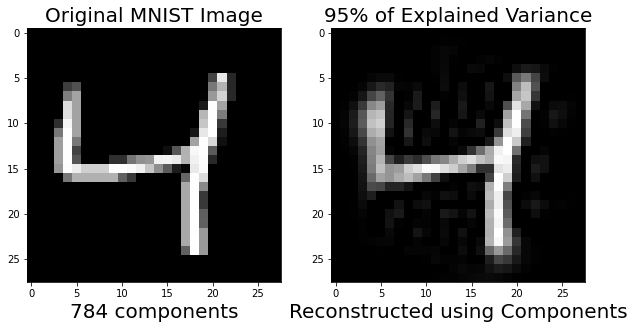

In [0]:
plt.figure(figsize=(10,5));

plt.subplot(1, 2, 1);
plt.imshow(mnist.data[2].reshape(28,28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.xlabel('784 components', fontsize = 20)
plt.title('Original MNIST Image', fontsize = 20);

plt.subplot(1, 2, 2);
plt.imshow(approximation[2].reshape(28, 28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.xlabel('Reconstructed using Components', fontsize = 20)
plt.title('95% of Explained Variance', fontsize = 20);

#### 3.1.3.3. Should we scale the data?

* how (and whether or not we actually should) scale the data is a controversial topic...

* ML engineers argue it is necessary in most cases because variance could to be low/high in features of the data that are on a smaller/larger scale

    * eg. the mile is 1.6^2 the mile in the British metric system, lb vs kilo, or cm vs. inch 


* algorithms which use Euclidean Distance measure (eg. PCA, KNN) are sensitive to these differences in scale/magnitude because the relationship between different features will be disproportinal

  * eg. larger scales will dominate

* normalisation **should** be performed when the scale of a feature is irrelevant and/or misleading to give equal weight to each in the calculation


* normalization **should not** be performed when a feature's preset scale is meaningful

  * eg. survey data where each question is 1 to 5

    * eg. rare values would be distorted



---


* different applications perform better with different types of scaling

* eg. standard scaling is often used for PCA since is centers data around 0



## 3.2. Cross Validation in Large Data

### 3.2.1. Leave one Out Problems

* the "*leaving one out*" - method is often better referred to as *K-fold* cross-validation (with k being 1)

* with large data we could have more than **n^2** work in this case

  * one solution could be to do **q < n** points only

* we must be careful to keep the number of predicters low in this method though too


### 3.2.2. Holdout Sets

* **hold out sets** are when we hold out a chunk of our data for training and save the rest for testing (eg. playing the part of 'new data')

* lets try 'holding out' 1000 points of the programmers and engineer data

#### Ex. Programmer & Engineer Wages Data

In [53]:
import pandas as pd

### INSERT YOUR PATH to data HERE: ###
my_path = '/content/drive/My Drive/ecs171_yancey/Lecture_Notes/Chapter_3/peDumms.csv'

# load CSV using pandas library
pe = pd.read_csv(my_path)


pe = pe.iloc[:,sum([[1], list(range(18,30)), [32,31]], [])]
# look at the first few rows and show features 
pd.DataFrame(pe.iloc[:,14])

,wageinc
0,75000
1,12300
2,15400
3,0
4,160
...,...
20085,39800
20086,40500
20087,80000
20088,3000


* we can use `sklearn`'s `train_test_split` to select random indices from the data for the holdout set

* our best k can be found by running knn for k up through 75, and then taking the minimum value from the overallLoss function outputs

In [55]:
from sklearn.model_selection import train_test_split

# can also create all 4 sets. at once
train_X, test_X, train_Y, test_Y = train_test_split(pe.iloc[:,0:14],pd.DataFrame(pe.iloc[:,14]), test_size = 1000)

print(len(train_X))
print(len(train_Y))
print(len(test_X))
print(len(test_Y))

knnout, nn = kNN(train_X,train_Y,test_X,75,regress=True,allK=True)

19090
19090
1000
1000


In [0]:
def findOverallLoss(ypreds,Y):
  err = abs(ypreds.reset_index(drop=True) - Y.reset_index(drop=True).values.squeeze())
  MAPE = err.mean(axis=1)
  return MAPE

In [57]:
losses = findOverallLoss(knnout,test_Y)
print('The best k is', losses.index[losses == min(losses)][0])
# note that the value below depends on the random indices selected above

The best k is 29


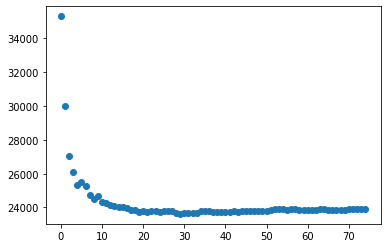

In [58]:
import matplotlib.pyplot as plt

import numpy as np

plt.plot(losses, 'o')

#### 3.2.2.2. Why only 1000?


* the choice of the hold-out set is another trade-off decision

* after k is chosed we re-fit (re-train) our model using the k we found before predicting any future cases

  * a) on one hand we could have done **better** if we had **less** in our test set (hold out set) because we would have trained on more data

  * b) but on the other hand when the test set gets **smaller**, we are making our prediction on a smaller set of values and we could be **overfitting** (that k might not be best for other/larger test sets


* this is actually another case of the **bias-vs-variance** tradeoff

  * a refers to **bias**

  * b refers to **variance** 


### 3.2.3. K-Fold Cross Validation

* one way we could reduce variance further though is by doing multiple splits of 1000 from the data

* if we did all 20 possible this would be called 20-fold cross-validation

* since some sets would over-estimate it, while. others would underestimate it we reduce both bias and variance by averaging the k from all splits



## 3.3. Pitfall: Another form of P-hacking

* take a second look at the bumpyness in the graph above...

* this stems from sampling variation (eg. leave one more k out or add one more in and it changes our accuracy significantly)

  * so minimizing the k isnt really accurate either

* it may have been better to take the median of the neighboring points here

### 3.3.1. Million song Data

* but what if we have 2 hyperperameters?

* lets do another example with thee million songs data

In [0]:
import pandas as pd
import numpy as np
### INSERT YOUR PATH to data HERE: ###
my_path = '/content/drive/My Drive/ecs171_yancey/Lecture_Notes/Chapter_3/YearPredictionMSD.txt'

# load CSV using pandas library
ms = pd.read_csv(my_path, header=None)
X = ms.iloc[:,1:]
Y = ms.iloc[:,0]
newx = X.iloc[0:1,:]



* these are the test/train sizes chosen from the book; lets do this small example of p-hacking on the ms data:

In [0]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_Y, test_Y = train_test_split(X,pd.DataFrame(Y), train_size=800,test_size =200)

* first lets scale our test and train data, ***before*** doing PCA 



In [0]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


X = train_X
newx = test_X

scaler = StandardScaler()
scaler.fit(train_X)

X = scaler.transform(train_X)
newx = scaler.transform(test_X)

pca = PCA(n_components=85)
pca.fit(X)
X_pca = pca.transform(X)
newx_pca = pca.transform(newx)

* now we just need to 

In [0]:
def findOverallLoss(ypreds,Y):
  err = abs(ypreds.reset_index(drop=True).T - Y.reset_index(drop=True).values.squeeze())
  MAPE = err.mean(axis=1)
  return MAPE

In [59]:
nrkout = 0

kout = pd.DataFrame(columns=['i', 'j','loss'])

for k in range(5,11,5):
  for pcs in range(5,86,5):
    
    knnout, nn = kNN(X_pca[:,0:pcs],train_Y,newx_pca[:,0:pcs],k,scaleX=False)
    i = (k+1)/5 
    j = (pcs+1)/5
    
    kout.loc[nrkout,'i'] = i
    kout.loc[nrkout,'j'] = j
    loss = round(findOverallLoss(knnout, test_Y)[0],2)
    c = loss
    nrkout = nrkout + 1

ValueError: ignored

In [0]:
print(min(kout.loc[:,'loss'].index))
kout.loc[:,'loss']

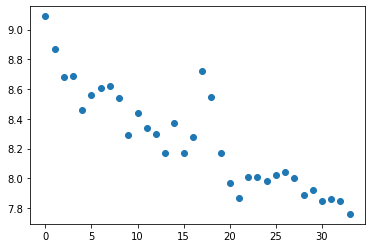

In [49]:
import matplotlib.pyplot as plt

import numpy as np

plt.plot(kout.loc[:,'loss'], 'o')

* the loss values are even more scattered! 